In [1]:
script = False
cluster = False

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
import timm

import seaborn as sn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps
#from transformers import ViTFeatureExtractor, ViTForImageClassification

from memory_profiler import memory_usage
import random
import os
import gc
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt

if(script):
    from tqdm import tqdm
else: 
    from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        #print(labels)
        #tensor_tmp = torch.tensor(labels.values, dtype=torch.float32)
        #self.labels = tensor_tmp
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        """
        #Plotting with Astropy and saving as png (not used right now)
        print('Astropy')
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.savefig('Image.png', bbox_inches='tight')
        plt.close()
        new_image = Image.open('Image.png')
        return(new_image)
        """
        #new_image = np.empty((3, 46, 46)) #I NEED TO CHANGE MY IMAGE SIZES!!!!!!
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        #label = self.labels.iloc[idx].to_dict()
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        #print(sample)
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()


In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
seed_everything(9)

if(cluster):
    path = '/data/des90.a/data/sgonzal/training_data/' #DES cluster
    path = '/Data/' #CHTC
else:
    path = '/Users/jimenagonzalez/research/DSPL/Modeling_strong_lenses/simulations/Data/fit_files/' #local
    
#200
npos = 1000
num_workers = 0
num_epochs = 20

hdu_list = fits.open(path + 'simu_11.fits')
print(len(hdu_list[1].data))
idx = random.sample(range(len(hdu_list[1].data)), npos)
images_dataset  = hdu_list[1].data[idx,:].astype(np.float32)
data_dataset = pd.DataFrame(hdu_list[2].data[:][idx])
data_dataset = data_dataset.drop('TILENAME', axis=1)
hdu_list.close()

new_data = data_dataset[data_dataset['e1_lens_light'] > -2]
images_dataset = images_dataset[new_data.index]
data_dataset = new_data.reset_index(drop=True)
labels_dataset = data_dataset.drop(['Y6_COADD_OBJECT_ID', 'HPIX_16384', 'HPIX_4096', 'DNF_ZMEAN_SOF', 'RA', 'DEC', 
        'FLUX_RADIUS_G', 'FLUX_RADIUS_R', 'FLUX_RADIUS_I', 'FLUX_RADIUS_Z', 'KRON_RADIUS', 'GAP_FLUX_G', 
        'MOF_BDF_FLUX_G', 'MOF_PSF_FLUX_G', 'SOF_BDF_FLUX_G', 'SOF_PSF_FLUX_G', 'MAG_AUTO_G', 'MAG_APER_4_G', 
        'MAG_APER_8_G', 'SOF_BDF_G_1', 'Y3_COADD_OBJECT_ID', 'REFMAG', 'REFMAG_ERR', 'LUM', 'ZREDMAGIC', 
        'ZREDMAGIC_E', 'CHISQ', 'Z_LENS', 'MAG_G', 'MAG_R', 'MAG_I', 'MAG_Z', 'MAG_ERR_G', 'MAG_ERR_R', 'MAG_ERR_I', 
        'MAG_ERR_Z', 'ZG', 'ZR', 'ZI', 'ZZ', 'SOF_BDF_G_2', 'IMAFLAGS_ISO_G', 'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I', 
        'IMAFLAGS_ISO_Z', 'EXT_COADD', 'FWHM_WMEAN_G', 'FWHM_WMEAN_R', 'FWHM_WMEAN_I', 'FWHM_WMEAN_Z', 
        'SKYBRITE_WMEAN_G', 'SKYBRITE_WMEAN_R', 'SKYBRITE_WMEAN_I', 'SKYBRITE_WMEAN_Z', 'Z1', 'LENSED_MAG', 
        'mag_1', 'ISOLATION', 'MAGNIFICATION', 'POSITION1', 'n_sersic_lens_light'], axis = 1)
labels_dataset = torch.tensor(labels_dataset.values, dtype=torch.float32)

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

print(images_dataset.shape)

1000
(996, 3, 45, 45)


In [6]:
data_dataset

,Y6_COADD_OBJECT_ID,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,FLUX_RADIUS_Z,...,R_sersic_source_light,n_sersic_source_light,e1_source_light,e2_source_light,center_x_source,center_y_source,R_sersic_lens_light,n_sersic_lens_light,e1_lens_light,e2_lens_light
0,960152473,1247054644,77940915,0.492458,335.659784,-0.721947,5.455850,4.945062,4.951759,4.811171,...,0.521504,1.316327,-0.013180,0.019031,-0.144166,0.565679,1.438708,0.514728,0.046865,-0.029786
1,1278904477,1159492644,72468290,0.323066,36.997409,-4.091390,8.036552,6.947987,6.473565,6.514993,...,0.676463,3.832770,0.007050,-0.016746,-0.587868,0.144268,2.119239,1.850911,-0.134804,0.196908
2,1352007816,1163239269,72702454,0.360409,44.141352,0.111342,7.104679,6.829383,6.478793,6.618839,...,1.016762,2.984875,0.520613,-0.204683,-0.180273,-1.512968,1.873504,0.806683,-0.149411,0.066742
3,1300448425,1154555934,72159745,0.461595,25.850208,-6.406000,4.654430,4.205679,4.051973,4.223321,...,0.643720,2.741823,-0.371096,0.252639,0.917848,0.215516,1.227373,2.926563,-0.306718,0.164461
4,1249576009,1146480988,71655061,0.617710,32.861765,-9.289357,5.389746,5.374295,5.237794,5.175426,...,0.568295,0.960369,-0.013005,0.006417,0.193636,0.643832,1.421276,0.904615,0.016107,0.158036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,1141046038,1182537880,73908617,0.315295,16.945334,2.646496,6.512215,5.992780,5.621764,5.630191,...,0.537165,3.925636,0.025644,0.016239,0.297514,0.995524,1.717271,2.819996,0.065103,-0.025151
992,1030042348,1140440134,71277508,0.566676,358.967743,-2.210665,6.525685,4.064786,4.019706,3.966743,...,0.775735,3.120626,-0.010474,-0.002855,0.794481,-0.060741,1.720823,2.586463,0.002580,-0.042416
993,948285626,1246699933,77918745,0.535241,331.734717,-0.963660,7.835247,7.441561,7.012249,6.965171,...,1.135790,3.120659,-0.260998,-0.014111,0.413628,-0.363370,2.066155,2.676307,-0.186296,0.058424
994,1196089247,1168415549,73025971,0.466917,26.456576,-0.564332,5.881231,5.580157,5.470932,5.348233,...,0.886850,3.520138,-0.269916,-0.149046,1.314137,-1.055237,1.550881,1.493668,0.172295,-0.068758


In [7]:
train_dataset, other_dataset = make_train_test_datasets(images_dataset, data_dataset, labels_dataset, test_size=0.2, transform=transform)
valid_dataset, test_dataset = make_train_test_datasets(other_dataset.images, other_dataset.data, other_dataset.labels, test_size=0.5, transform=transform)
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 796, len test dataset: 100


In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
torch.save(test_loader, 'test_loader.pth')

In [9]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        if(not cluster):
            self.model = EfficientNet.from_pretrained('efficientnet-b0',  num_classes=n_classes)
            torch.save(self.model.state_dict(), 'initial_model.pt')
        else:
            self.model = EfficientNet.from_name('efficientnet-b0',  num_classes=n_classes)
            self.model.load_state_dict(torch.load('initial_model.pt'))

    def forward(self, x):

        x = self.model(x)

        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        for i, sample in enumerate(tqdm(train_loader)):

            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output = torch.squeeze(output)
            
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Calculate Accuracy
            accuracy = loss # I NEED TO UPDATE THIS AKDMFMAKDFMAKFGOIAJEROFMAOIMGOIAJMROGKMAOFMGAOFDLGMAKLFMGK
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader.dataset)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)):
            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = loss # TO UPDATE ADMFKAMDKFMAKDMFKAJDKGJNAOIERJGOIMRGOIJROITJIOJRGIOSJIFGJMSOIRGJISRJI
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy
        
        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader.dataset)

In [10]:
model = ViTBase16(n_classes=14, pretrained=True)

criterion = torch.nn.MSELoss() #nn.CrossEntropyLoss() #nn.CrossEntropyLoss() #nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

learning_rate = 0.0001 #0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0
cpu


In [11]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    
    best_val_loss = float('inf') # track of best loss
    model_data = pd.DataFrame()

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss.cpu().data.numpy())
        train_accs.append(train_acc.cpu().data.numpy())
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss.cpu().data.numpy())
            valid_accs.append(valid_acc.cpu().data.numpy())
            gc.collect()
            
            if(valid_loss.cpu().data.numpy() < best_val_loss):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, name_model)
                best_val_loss = valid_loss.cpu().data.numpy()
                
    model_data['train_losses'] = train_losses
    model_data['valid_losses'] = valid_losses
    model_data['train_accs'] = train_accs
    model_data['valid_accs'] = valid_accs
    model_data.to_csv('Complete_model.csv', index=False)

In [12]:
def plot_performance(cnn):
    loss_train = [x.item() for x in cnn.loss_train]
    loss_valid = [x.item() for x in cnn.loss_valid]
    train_acc = [x.item() for x in cnn.train_acc]
    valid_acc = [x.item() for x in cnn.validation_acc]
    
    x = np.linspace(1,len(cnn.loss_train),len(cnn.loss_train))
    fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
    
    ax1.set_title('Losses')
    ax1.set_xlabel('Epoch')
    ax1.scatter(x, loss_train, color = 'skyblue', alpha = 0.8, label = 'Training loss')
    ax1.scatter(x, loss_valid, color = 'limegreen', alpha = 0.8,  label = 'Validation loss')
    ax1.legend()
    
    ax2.set_title('Performance. Max: {:.4f}%'.format(100*cnn.validation_acc[-1].item()))
    ax2.set_xlabel('Epoch')
    ax2.scatter(x, train_acc, color = 'skyblue', alpha = 0.8,  label = 'Training Accuracy')
    ax2.scatter(x, valid_acc, color = 'limegreen', alpha = 0.8,  label = 'Validation Accuracy')
    ax2.legend()
    
    if(script):
        plt.savefig('Performance.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show(block=True)

In [13]:
name_model = 'model2.pt' #other, model
#                          model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
mem_usage = memory_usage(( fit_tpu, (model, name_model, num_epochs, device, criterion, optimizer, train_loader, valid_loader)))


EPOCH 1 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 1 - LOSS: 0.048542119562625885, ACCURACY: 0.048542119562625885

start valid_loader
EPOCH 1 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.050788965076208115, ACCURACY: 0.050788965076208115

EPOCH 2 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 2 - LOSS: 0.01530344970524311, ACCURACY: 0.01530344970524311

start valid_loader
EPOCH 2 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.026973135769367218, ACCURACY: 0.026973135769367218

EPOCH 3 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 3 - LOSS: 0.009893292561173439, ACCURACY: 0.009893292561173439

start valid_loader
EPOCH 3 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.02580648474395275, ACCURACY: 0.02580648474395275

EPOCH 4 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 4 - LOSS: 0.00819361861795187, ACCURACY: 0.00819361861795187

start valid_loader
EPOCH 4 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.03725890815258026, ACCURACY: 0.03725890815258026

EPOCH 5 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 5 - LOSS: 0.007083204109221697, ACCURACY: 0.007083204109221697

start valid_loader
EPOCH 5 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.19085441529750824, ACCURACY: 0.19085441529750824

EPOCH 6 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 6 - LOSS: 0.006287773605436087, ACCURACY: 0.006287773605436087

start valid_loader
EPOCH 6 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.24389232695102692, ACCURACY: 0.24389232695102692

EPOCH 7 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 7 - LOSS: 0.005524155683815479, ACCURACY: 0.005524155683815479

start valid_loader
EPOCH 7 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.36958855390548706, ACCURACY: 0.36958855390548706

EPOCH 8 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 8 - LOSS: 0.004883216228336096, ACCURACY: 0.004883216228336096

start valid_loader
EPOCH 8 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 1.1393744945526123, ACCURACY: 1.1393744945526123

EPOCH 9 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 9 - LOSS: 0.004566763993352652, ACCURACY: 0.004566763993352652

start valid_loader
EPOCH 9 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.017615437507629395, ACCURACY: 0.017615437507629395

EPOCH 10 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 10 - LOSS: 0.004226295277476311, ACCURACY: 0.004226295277476311

start valid_loader
EPOCH 10 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.017898429185152054, ACCURACY: 0.017898429185152054

EPOCH 11 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 11 - LOSS: 0.0037308207247406244, ACCURACY: 0.0037308207247406244

start valid_loader
EPOCH 11 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.014690738171339035, ACCURACY: 0.014690738171339035

EPOCH 12 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 12 - LOSS: 0.0036931431386619806, ACCURACY: 0.0036931431386619806

start valid_loader
EPOCH 12 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.012299563735723495, ACCURACY: 0.012299563735723495

EPOCH 13 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 13 - LOSS: 0.0031973940785974264, ACCURACY: 0.0031973940785974264

start valid_loader
EPOCH 13 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.009278028272092342, ACCURACY: 0.009278028272092342

EPOCH 14 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 14 - LOSS: 0.0030945935286581516, ACCURACY: 0.0030945935286581516

start valid_loader
EPOCH 14 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.008631767705082893, ACCURACY: 0.008631767705082893

EPOCH 15 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 15 - LOSS: 0.0027645982336252928, ACCURACY: 0.0027645982336252928

start valid_loader
EPOCH 15 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.008307628333568573, ACCURACY: 0.008307628333568573

EPOCH 16 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 16 - LOSS: 0.0027558947913348675, ACCURACY: 0.0027558947913348675

start valid_loader
EPOCH 16 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.008470785804092884, ACCURACY: 0.008470785804092884

EPOCH 17 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 17 - LOSS: 0.002727881073951721, ACCURACY: 0.002727881073951721

start valid_loader
EPOCH 17 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.008572135120630264, ACCURACY: 0.008572135120630264

EPOCH 18 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 18 - LOSS: 0.0026283254846930504, ACCURACY: 0.0026283254846930504

start valid_loader
EPOCH 18 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.00869520753622055, ACCURACY: 0.00869520753622055

EPOCH 19 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 19 - LOSS: 0.00242016464471817, ACCURACY: 0.00242016464471817

start valid_loader
EPOCH 19 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.00802847370505333, ACCURACY: 0.00802847370505333

EPOCH 20 - TRAINING...


  0%|          | 0/40 [00:00<?, ?it/s]


	[TRAIN] EPOCH 20 - LOSS: 0.0024917502887547016, ACCURACY: 0.0024917502887547016

start valid_loader
EPOCH 20 - VALIDATING...


  0%|          | 0/5 [00:00<?, ?it/s]

	[VALID] LOSS: 0.008067692629992962, ACCURACY: 0.008067692629992962



In [14]:
print('Maximum memory usage: %s' % max(mem_usage))

Maximum memory usage: 2277.78515625


In [15]:
name = 'model2.pt'#'model.pt'#'other.pt' 
model = torch.load(name)
print('Maximum validation accuracy: {:.2f}%'.format(100*model.validation_acc[-1].item())) #Doesn't mean anything

Maximum validation accuracy: 0.80%


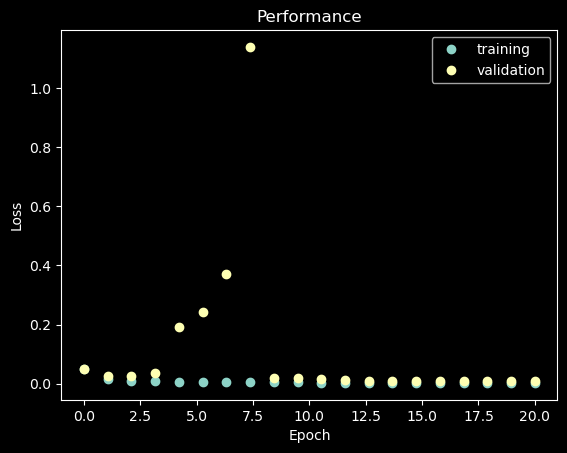

In [16]:
# Plotting complete training
data_model = pd.read_csv('Complete_model.csv')
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
x = np.linspace(0, len(data_model), len(data_model))
plt.title('Performance')
plt.plot(x, data_model['train_losses'].values, 'o', label='training')
plt.plot(x, data_model['valid_losses'].values, 'o', label='validation')
plt.legend()
plt.show()

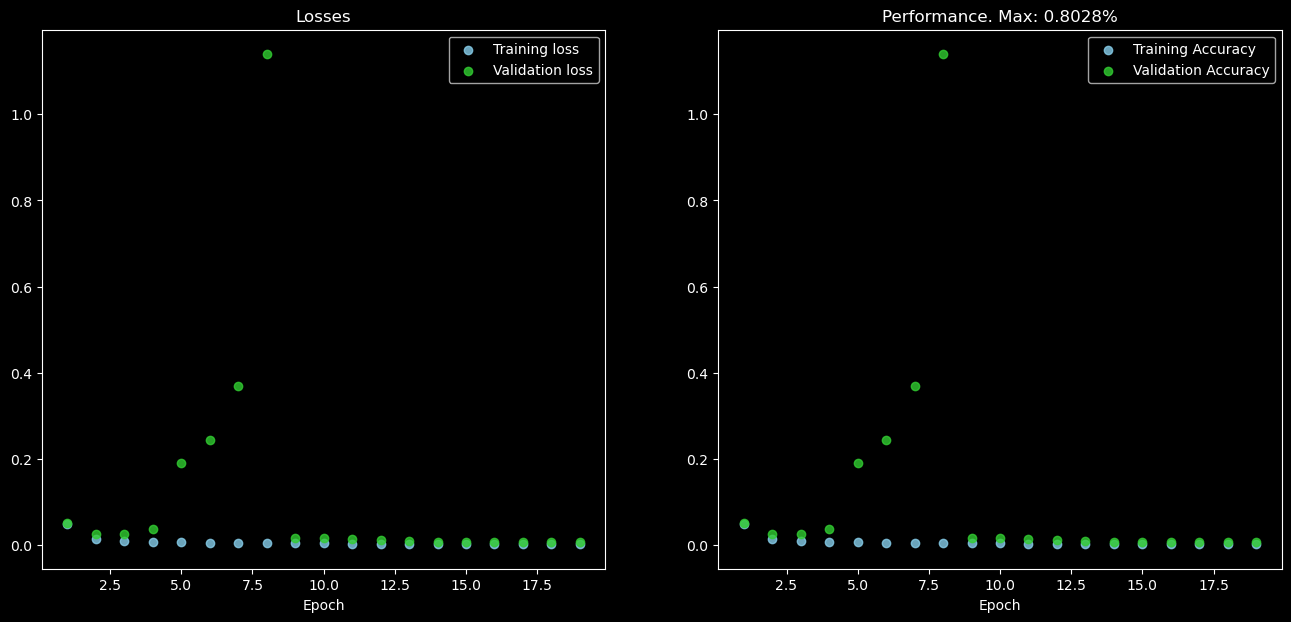

In [17]:
# Plotting only saved model
plot_performance(model)

In [18]:
def testing_analysis(test_loader):
    predicted_data, true_data = pd.DataFrame(), pd.DataFrame()
    for i, sample in enumerate(tqdm(valid_loader)):
        data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
        # move tensors to GPU if CUDA is available
        if device.type == "cuda":
            data, target = data.cuda(), target.cuda()

        #forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        output = pd.DataFrame(output.detach().numpy())
        
        predicted_data = predicted_data.append(output)
        true_data = true_data.append(pd.DataFrame(target.numpy()))
        
    return(predicted_data, true_data)

In [19]:
names = ['EINSTEIN_RADIUS', 'e1_lens', 'e2_lens', 'center_x_lens', 'center_y_lens', 'R_sersic_source_light',
       'n_sersic_source_light', 'e1_source_light', 'e2_source_light', 'center_x_source', 'center_y_source', 
        'R_sersic_lens_light', 'e1_lens_light', 'e2_lens_light']
predicted_data, true_data = testing_analysis(test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

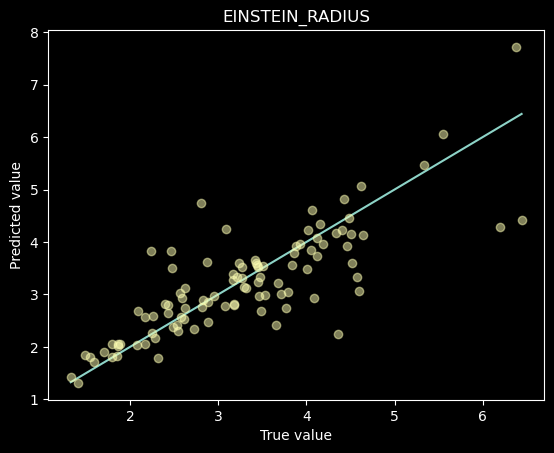

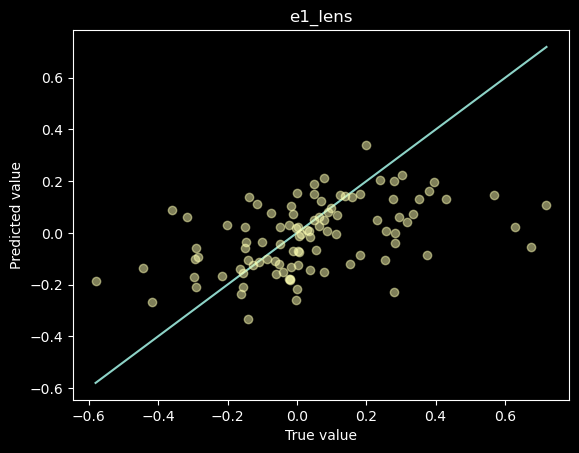

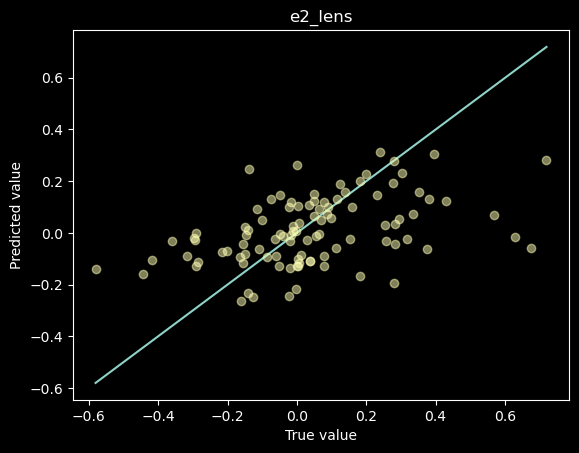

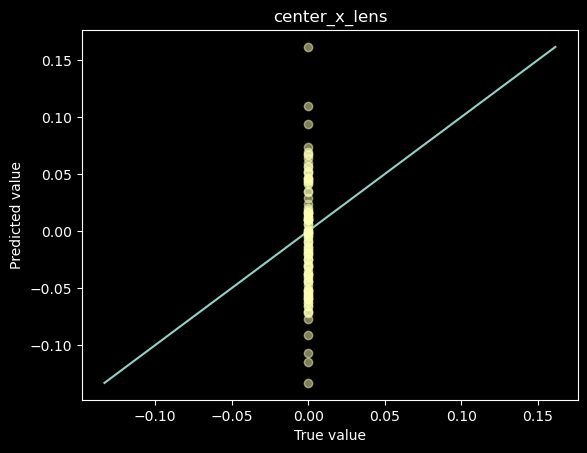

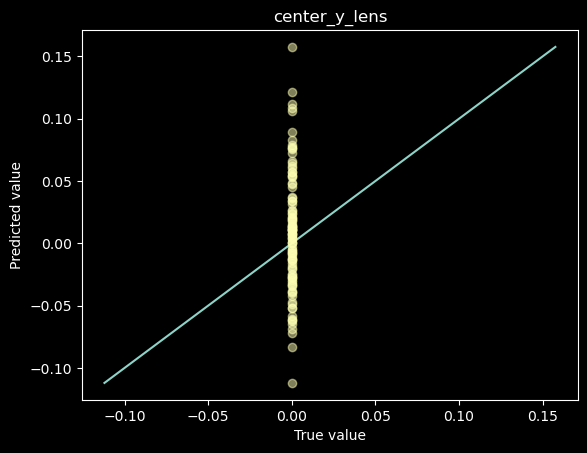

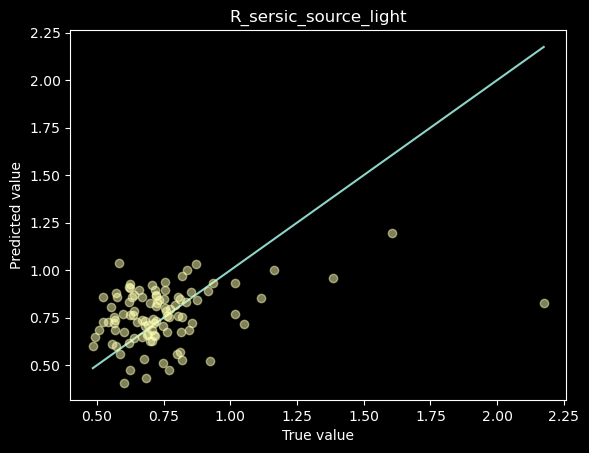

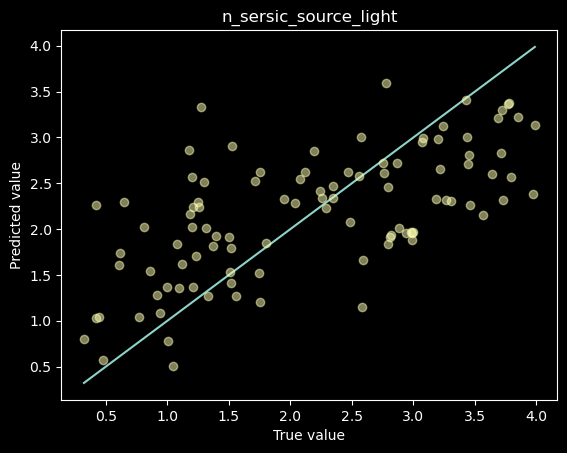

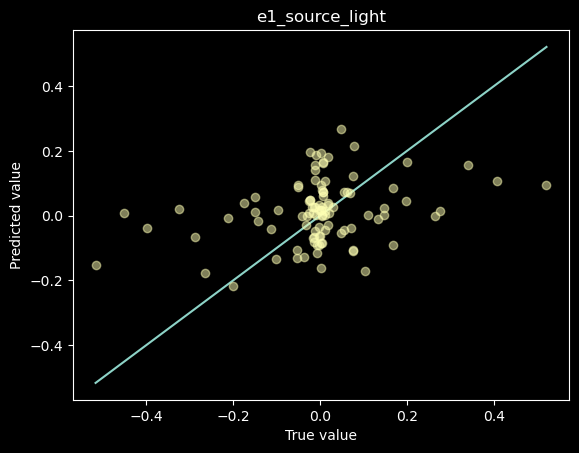

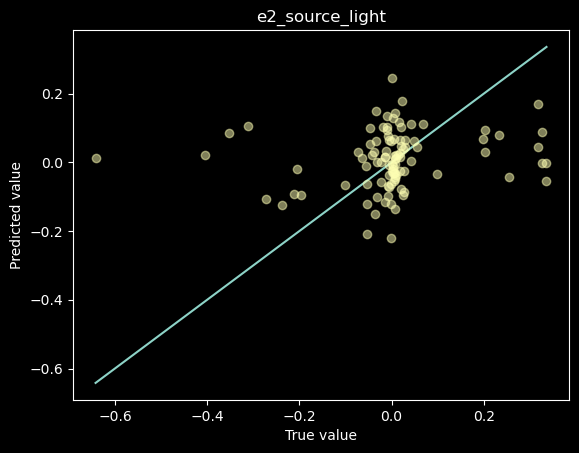

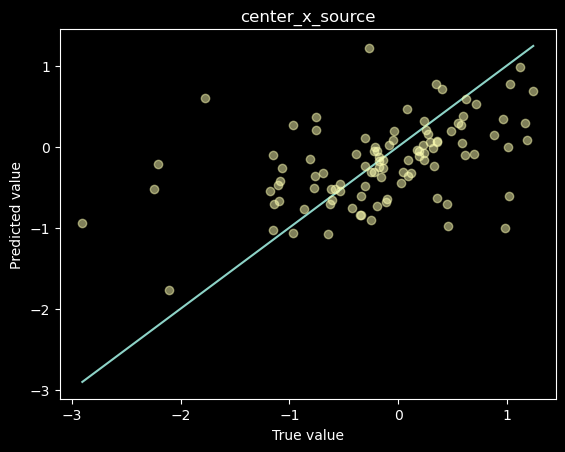

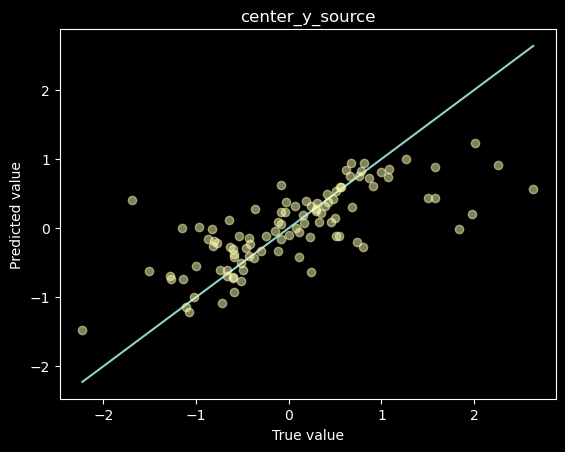

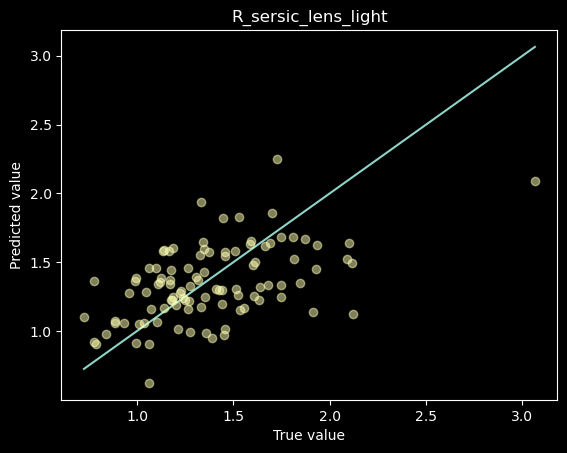

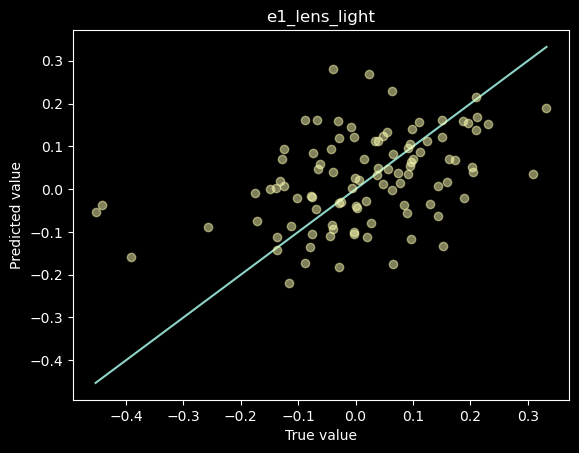

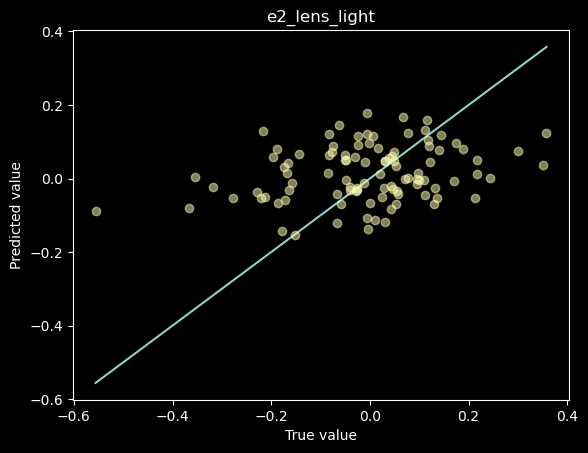

In [20]:
j = 0
for name in true_data.columns:
    x = np.linspace(min(true_data[name]), max(true_data[name]), 1000)
    if(names[j] == 'center_x_lens' or names[j] == 'center_y_lens'):
        x = np.linspace(min(predicted_data[name]), max(predicted_data[name]), 1000)
    
    plt.figure()
    plt.title(names[j])
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.plot(x, x)
    plt.plot(true_data[name], predicted_data[name], 'o', alpha = 0.5)
    plt.show()
    j += 1

In [30]:
def make_plot_all(objects, title, data, Q, stretch, minimum):
    for i in range(len(objects)):
        if(i%7 == 0):
            plt.figure(figsize=(10,2))
            for j in range(7):
                if(i+j > len(objects)-1): break
                plt.subplot(1,7,j+1)
                #print(data['COADD_OBJECT_ID'].iloc[i+j]) 
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], 
                                    Q=Q, stretch=stretch, minimum=minimum)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            #plt.savefig(png_filepath + title + '.png', bbox_inches='tight')
            plt.show() 

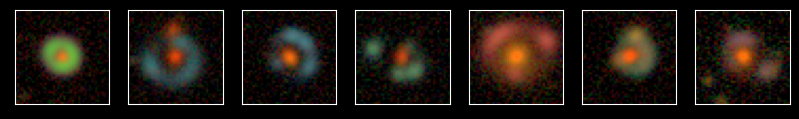

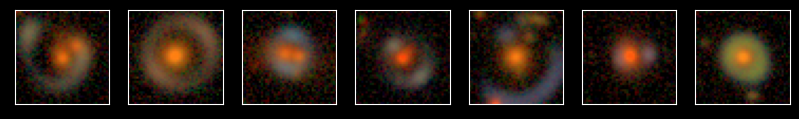

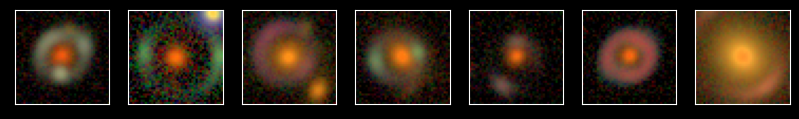

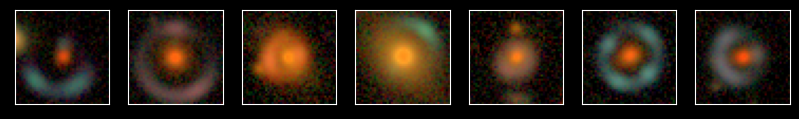

In [31]:
num = 28
idx = random.sample(range(len(data_dataset)), num)
images_tmp = images_dataset[idx]
data_tmp = data_dataset.iloc[idx]
make_plot_all(images_tmp, 'title', data_tmp, 9, 40, (0, 0, 0))

In [23]:
def make_histo(name):
    plt.figure(figsize=(16,5)) 

    plt.subplot(1,2,1)
    plt.title('All distribution: ' + str(name))
    #data_all = np.concatenate((right_pos[name], wrong_pos[name]))
    plt.hist(data_dataset[name], edgecolor = 'black')
    
    if(script):
        plt.savefig('Histogram_' + str(name), bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        

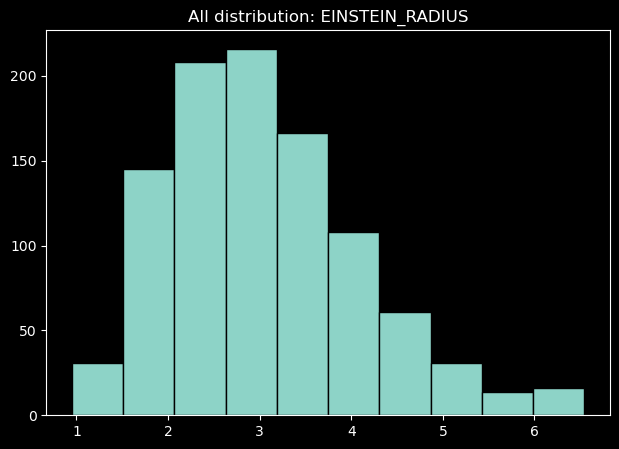

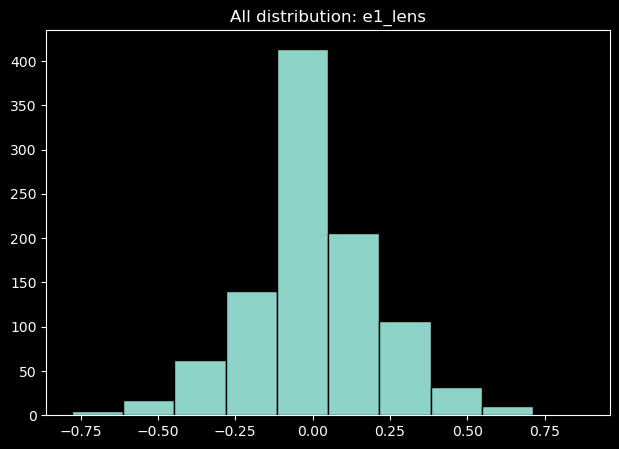

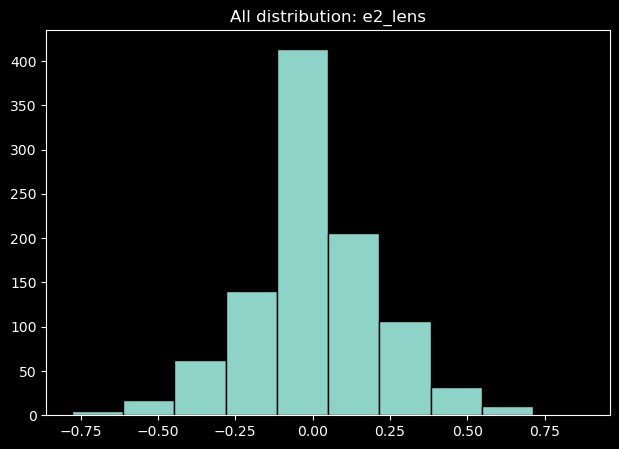

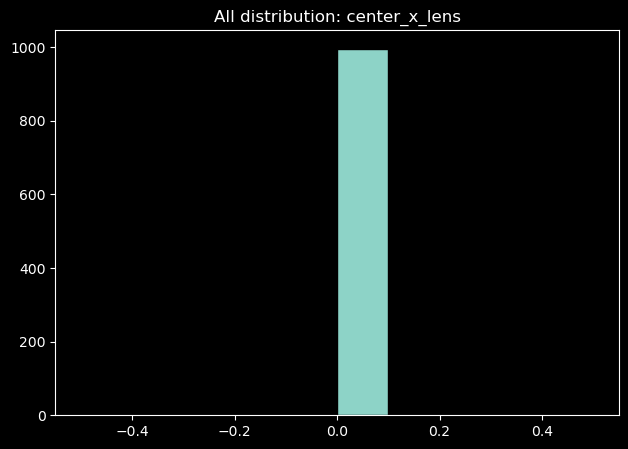

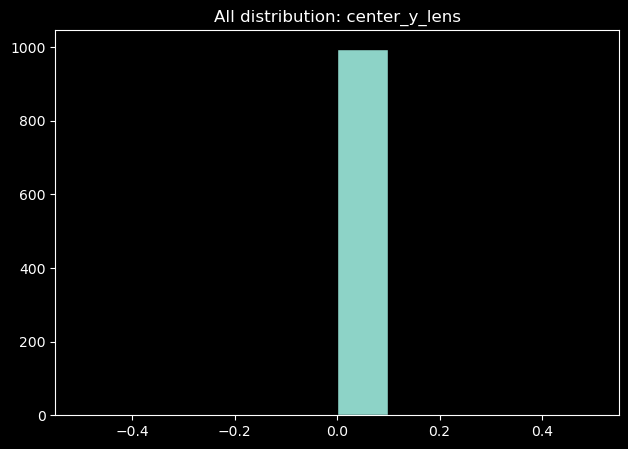

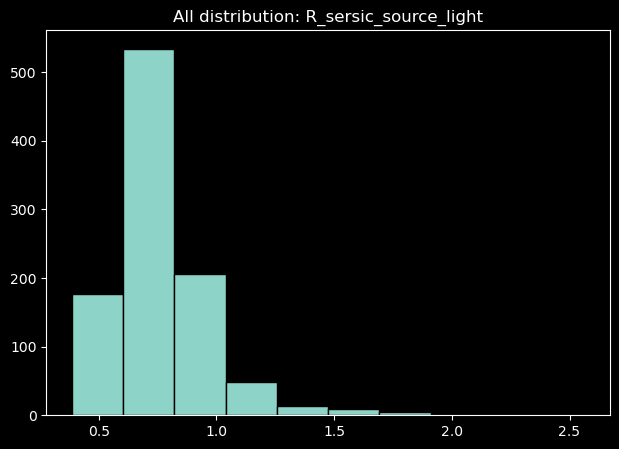

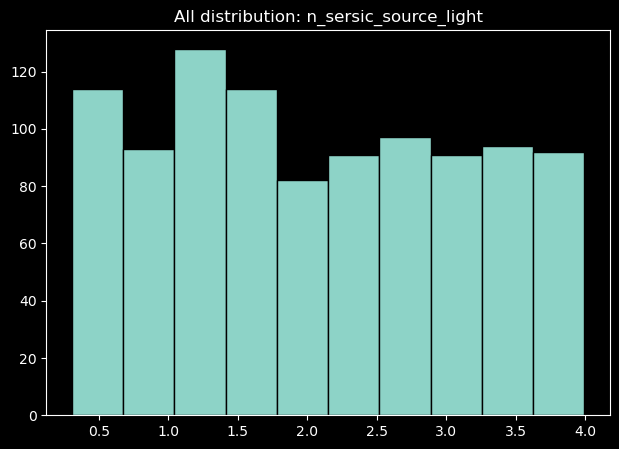

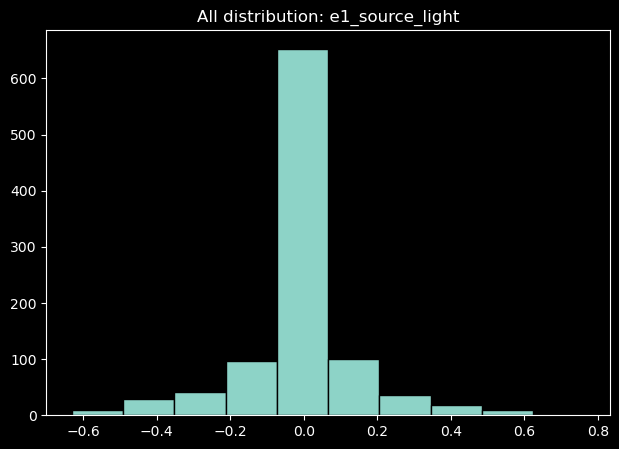

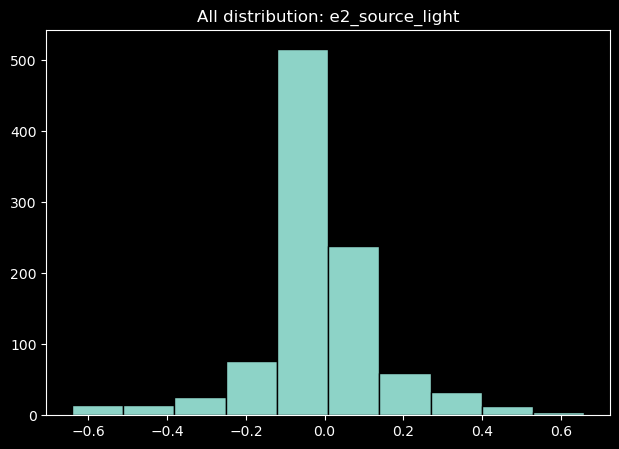

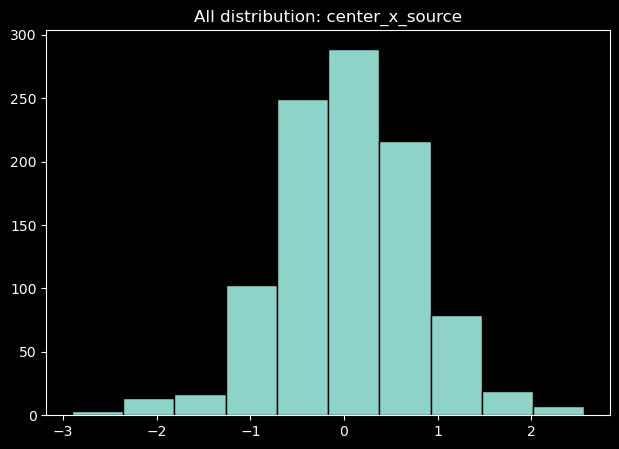

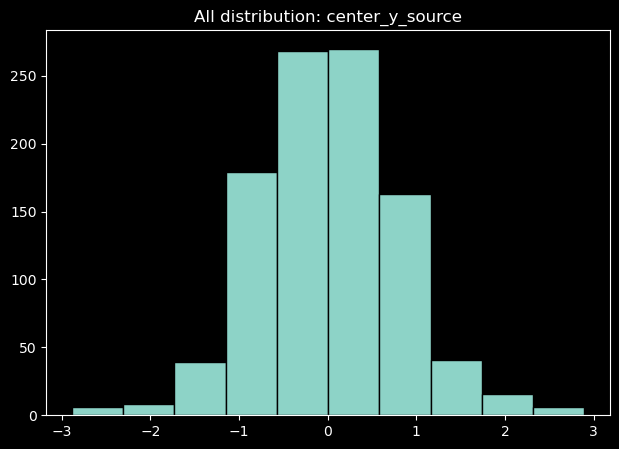

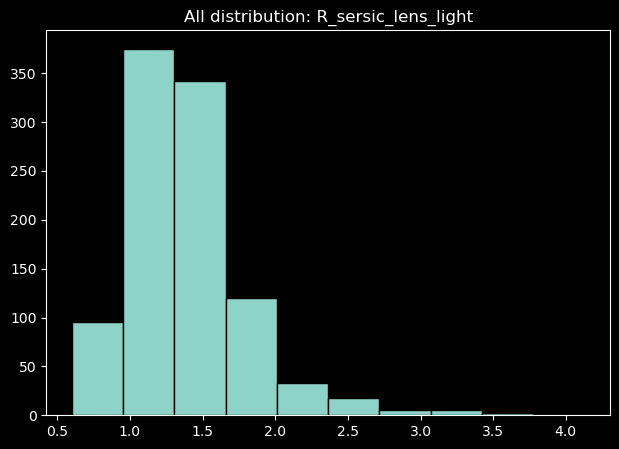

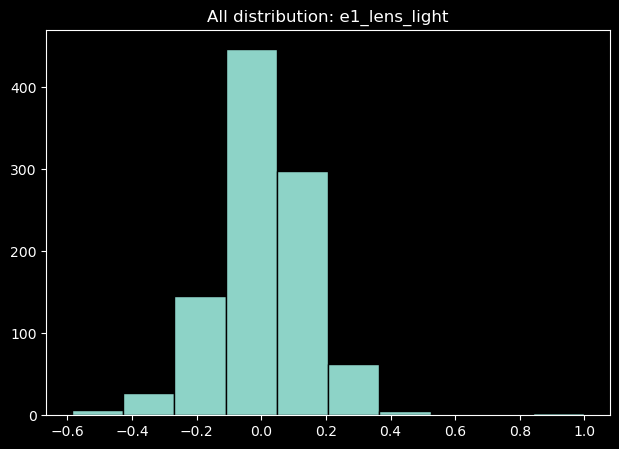

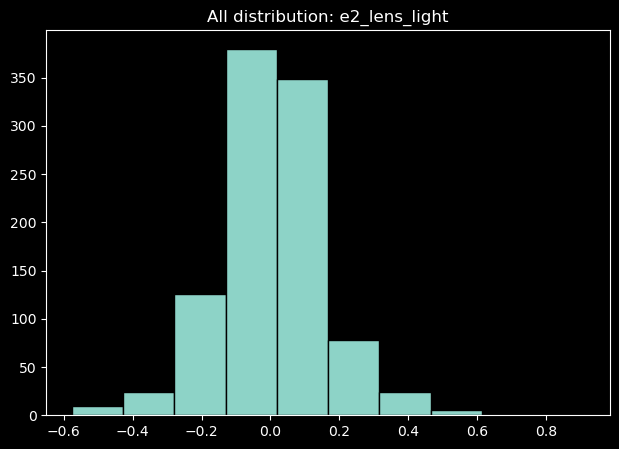

In [24]:
for name in names:
    make_histo(name)